Import Library

In [1]:
# Run this!

# A specific version of opencv was used for dnn upscalling, please uninstall any current versions 
# and use the following command for the installation "pip install --upgrade opencv-contrib-python"
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import io
from cv2 import dnn_superres
from moviepy.editor import *
from moviepy.audio.fx.all import audio_fadeout, audio_fadein
from PIL import ImageDraw, ImageFilter, Image, ImageEnhance, ImageColor, ImageOps, ImageFont
from IPython.display import Video
from rembg import remove
from tqdm import tqdm
from io import BytesIO

General Function

In [2]:
#Run This!


def blur_image(image_path, output_path, radius=2):
    # Open the image
    image = Image.open(image_path)
    
    # Apply Gaussian Blur
    blurred_image = image.filter(ImageFilter.GaussianBlur(radius))
    
    # Save the blurred image
    blurred_image.save(output_path)
    
    # Display the image
    plt.imshow(blurred_image)
    plt.axis('off')  # Hide axis
    plt.show()
    
    plt.show()


def imageUpscale(img_path, output_path) -> None:
    # Load the image
    img = cv2.imread(img_path)
    
    # Check if the image was loaded correctly
    if img is None:
        raise ValueError(f"Image not found or cannot be loaded from {img_path}")

    model_path = "../Model/EDSR_X4.pb"

    # Create and configure the super-resolution model
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel(model_path)
    sr.setModel("edsr", 4)
    
    # Perform upscaling
    upscaled_img = sr.upsample(img)

    # Save the upscaled image
    cv2.imwrite(output_path, upscaled_img)


def sharpen_image(image_path: str, output_path: str) -> None:
    # Open the original image using PIL
    original_image = Image.open(image_path)

    # Apply the sharpen filter
    sharpened_image = original_image.filter(ImageFilter.SHARPEN)

    # Convert the PIL image to RGB mode if it's not already
    if sharpened_image.mode != 'RGB':
        sharpened_image = sharpened_image.convert('RGB')

    # Convert the PIL image to a NumPy array
    sharpened_image_np = np.array(sharpened_image)

    # Display the image
    plt.imshow(sharpened_image_np)
    plt.axis('off')  # Hide axis
    plt.show()

    # Save the sharpened image using OpenCV
    cv2.imwrite(output_path, cv2.cvtColor(sharpened_image_np, cv2.COLOR_RGB2BGR))


def enhance_contrast(image_path, output_path, factor) -> None:
    # Open the original image
    image = Image.open(image_path)

    # Create an ImageEnhance object for contrast
    enhancer = ImageEnhance.Contrast(image)
    
    # Enhance the contrast
    enhanced_image = enhancer.enhance(factor)

    # Display the image
    plt.imshow(enhanced_image)
    plt.axis('off')  # Hide axis
    plt.show()
    
    # Save the enhanced image
    enhanced_image.save(output_path)

# Adjusts brightness of the input image by the specified factor
def adjust_brightness(image_path, output_path, factor):
    # Open the original image
    image = Image.open(image_path)

    # Create an ImageEnhance object for brightness
    enhancer = ImageEnhance.Brightness(image)
    
    # Adjust the brightness
    brightened_image = enhancer.enhance(factor)

    # Display the image
    plt.imshow(brightened_image)
    plt.axis('off')  # Hide axis
    plt.show()
    
    # Save the adjusted image
    brightened_image.save(output_path)


def histogram_equalization_color(image_path: str, output_path: str) -> None:
    # Open the image using OpenCV
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("Image not found or unable to open.")

    # Convert the image from BGR to YUV color space
    yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    # Perform histogram equalization on the Y channel
    yuv_image[:,:,0] = cv2.equalizeHist(yuv_image[:,:,0])

    # Convert back to BGR color space
    equalized_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR)

    # Convert the image from BGR to RGB for displaying with matplotlib
    equalized_image_rgb = cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(equalized_image_rgb)
    plt.axis('off')  # Hide axis
    plt.show()

    # Save the equalized image
    cv2.imwrite(output_path, equalized_image)


def overlay_texture(base_image_path, texture_image_path, output_path, alpha=0.4):
    # Load images
    base_image = Image.open(base_image_path).convert("RGBA")
    texture_image = Image.open(texture_image_path).convert("RGBA")
    
    # Resize texture to match base image size if necessary
    texture_image = texture_image.resize(base_image.size, Image.LANCZOS)
    
    # Create a new image for blending
    blended_image = Image.blend(base_image, texture_image, alpha)
    
    # Save the output image
    blended_image.save(output_path)

    # Display the image
    plt.imshow(blended_image)
    plt.axis('off')  # Hide axis
    plt.show()


def extract_frames(video_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_path = os.path.join(output_folder, f"{frame_count:04d}.png")  # Zero-padded filenames
        cv2.imwrite(frame_path, frame)
        frame_count += 1
    
    cap.release()
    print(f"Extracted {frame_count} frames to {output_folder}")

def make_black_background_transparent(input_folder, output_folder, lower_bound, upper_bound):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(input_folder):
        if filename.endswith(".png"):
            frame_path = os.path.join(input_folder, filename)
            frame = cv2.imread(frame_path, cv2.IMREAD_COLOR)

            # Convert BGR to BGRA (adding an alpha channel)
            b, g, r = cv2.split(frame)
            alpha = np.ones(b.shape, dtype=b.dtype) * 255  # Create alpha channel fully opaque

            # Create a mask for the specified color range
            lower_bound = np.array(lower_bound, dtype="uint8")
            upper_bound = np.array(upper_bound, dtype="uint8")
            mask = cv2.inRange(frame, lower_bound, upper_bound)
            
            # Set alpha to 0 for the masked areas
            alpha[mask != 0] = 0
            
            # Merge channels back
            frame_with_transparency = cv2.merge([b, g, r, alpha])
            frame_with_transparency = cv2.resize(frame_with_transparency, (1920, 1080))  # Ensure size
            
            # Save the frame with transparency
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, frame_with_transparency)
    
    print(f"Processed frames with transparency saved to {output_folder}")

def resize_frames_to_overlay(frame_folder, overlay_image_path):
    # Load the overlay image to get its dimensions
    overlay_image = cv2.imread(overlay_image_path)
    if overlay_image is None:
        raise FileNotFoundError(f"Overlay image not found: {overlay_image_path}")

    overlay_height, overlay_width = overlay_image.shape[:2]

    # Loop through each frame in the folder and resize it
    for frame_name in tqdm(os.listdir(frame_folder), desc="Resizing frames", unit="frame"):
        frame_path = os.path.join(frame_folder, frame_name)
        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Warning: Unable to read the frame file {frame_name}. Skipping...")
            continue
        
        # Resize the frame
        resized_frame = cv2.resize(frame, (overlay_width, overlay_height))
        
        # Save the resized frame
        cv2.imwrite(frame_path, resized_frame)


def adjust_frame_transparency_and_brightness(frame_folder, frame_alpha=0.3, brightness_beta=-50):
    for filename in os.listdir(frame_folder):
        if filename.endswith(".png"):
            frame_path = os.path.join(frame_folder, filename)
            frame = cv2.imread(frame_path, cv2.IMREAD_COLOR)

            if frame is not None:
                # Convert the frame to BGRA to add transparency
                frame_with_alpha = np.zeros((frame.shape[0], frame.shape[1], 4), dtype=np.uint8)
                frame_with_alpha[:, :, :3] = frame  # Copy RGB channels
                frame_with_alpha[:, :, 3] = int(frame_alpha * 255)  # Set alpha channel for frame

                # Adjust brightness
                frame_rgb = frame_with_alpha[:, :, :3].astype(np.float32)
                frame_rgb += brightness_beta
                frame_rgb = np.clip(frame_rgb, 0, 255).astype(np.uint8)
                frame_with_alpha[:, :, :3] = frame_rgb

                # Save the frame with adjusted transparency and brightness
                cv2.imwrite(frame_path, frame_with_alpha)


def add_bold_scrolling_text_to_image(image_path, text, output_video_path, duration=10, text_speed=100, text_size=50, text_color=(207, 161, 107), boldness=2):
    # Load the image
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    
    # Create a video writer object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_video_path, fourcc, 24, (width, height))
    
    # Load a font
    font_path = "path/to/arial.ttf"  # Update this path to a valid font file on your system
    font = ImageFont.truetype(font_path, text_size)

    # Create an image object to use with PIL
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_image)
    
    # Determine text bounding box for scrolling effect
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    
    # Calculate the total number of frames
    total_frames = int(duration * 24)
    
    for frame_number in range(total_frames):
        # Create a copy of the image
        frame_pil = pil_image.copy()
        frame_draw = ImageDraw.Draw(frame_pil)
        
        # Calculate text position for scrolling effect
        x = width - (text_speed * frame_number) % (width + text_width)
        y = 10  # Adjust y to place text at the top, with a 10-pixel margin from the top edge
        
        # Draw bold text
        for offset_x in range(-boldness, boldness+1):
            for offset_y in range(-boldness, boldness+1):
                if offset_x**2 + offset_y**2 <= boldness**2:  # Only draw within a circular area
                    frame_draw.text((x + offset_x, y + offset_y), text, font=font, fill=text_color)
        
        # Draw the text on the image
        frame_draw.text((x, y), text, font=font, fill=text_color)
        
        # Convert back to OpenCV format and write to video
        frame = cv2.cvtColor(np.array(frame_pil), cv2.COLOR_RGB2BGR)
        video_writer.write(frame)
    
    video_writer.release()
    print(f"Video saved as {output_video_path}")

# Adds audio to a video file with optional fade-in and fade-out effects
def add_audio_to_video(video_path, audio_path, output_path, fade_duration=3, audio_start_frac=0, audio_end_frac=1, volume=1):
    video = VideoFileClip(video_path)
    background_music = AudioFileClip(audio_path)

    audio_start = video.duration * audio_start_frac
    audio_end = video.duration * audio_end_frac

    if audio_end > video.duration:
        audio_end = video.duration
    
    audio_duration = audio_end - audio_start
    background_music = background_music.subclip(0, min(audio_duration, background_music.duration))

    background_music = audio_fadein(background_music, duration=fade_duration)
    background_music = audio_fadeout(background_music, duration=fade_duration)
    background_music = background_music.volumex(volume)

    if video.audio is None:
        final_audio = background_music.set_start(audio_start)
    else:
        background_music = background_music.set_start(audio_start)
        final_audio = CompositeAudioClip([video.audio, background_music])

    final_video = video.set_audio(final_audio)
    final_video.write_videofile(output_path, codec="libx264", audio_codec="aac")

    video.close()
    background_music.close()
    final_video.close()


Scene 1: Shrine

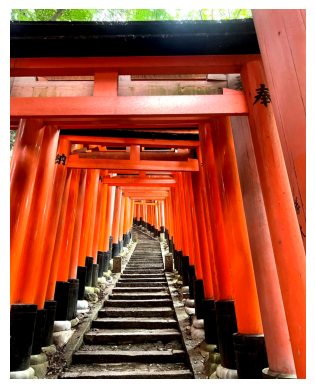

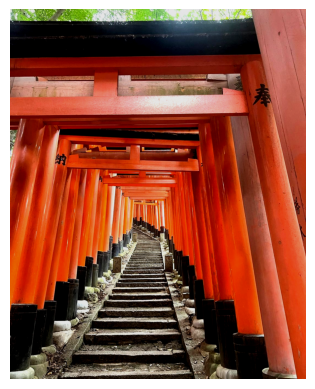

In [3]:
#Preprocess image

enhance_contrast("../Pic/Scene1/Shrine.png", "../Pic/Scene1/1.png", 1.5)

adjust_brightness("../Pic/Scene1/1.png", "../Pic/Scene1/2.png", 0.9)

Generate frame

In [4]:
#Make the video by frame

video = "../Pic/Scene1/Sakura.mp4"
OFrames = "../Video Frame/Ori"
TFrames = "../Video Frame/Aft"

# Define lower and upper bounds for the color black (you can adjust these values)
lower_black = [0, 0, 0]
upper_black = [50, 50, 50]

extract_frames(video, OFrames)
make_black_background_transparent(OFrames, TFrames, lower_black, upper_black)

Extracted 156 frames to ../Video Frame/Ori
Processed frames with transparency saved to ../Video Frame/Aft


Resize Frame

In [5]:
#Resize frame

frame_folder = "../Video Frame/Aft"
overlay_image_path = "../Pic/Scene1/2.png"
resize_frames_to_overlay(frame_folder, overlay_image_path)

Resizing frames: 100%|██████████| 156/156 [00:08<00:00, 17.95frame/s]


Overlay the video to the image

In [6]:
frame_folder = "../Video Frame/Aft"

adjust_frame_transparency_and_brightness(frame_folder, frame_alpha=0.3, brightness_beta=-50)

Adding Wind audio to the image animation

In [7]:
add_audio_to_video("../Processed Pic/Scene1.mp4", "../Pic/Scene1/Wind.mp3", "../Processed Pic/Scene1_with_audio.mp4", 
                    fade_duration=1, audio_start_frac=0, audio_end_frac=1)

Moviepy - Building video ../Processed Pic/Scene1_with_audio.mp4.
MoviePy - Writing audio in Scene1_with_audioTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../Processed Pic/Scene1_with_audio.mp4



Moviepy - Done !
Moviepy - video ready ../Processed Pic/Scene1_with_audio.mp4


Scene 2: Temple of Nikko

In [80]:
# Preprocess image

#Upscale the image
imageUpscale("../Pic/Scene2/TempleOfNikko.png", "../Pic/Scene2/PTempleOfNiko.png")

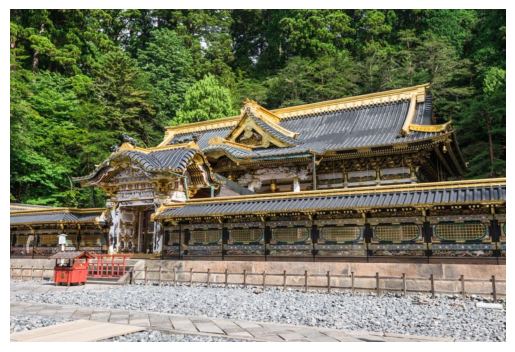

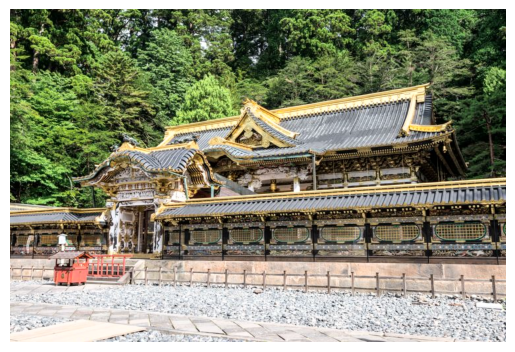

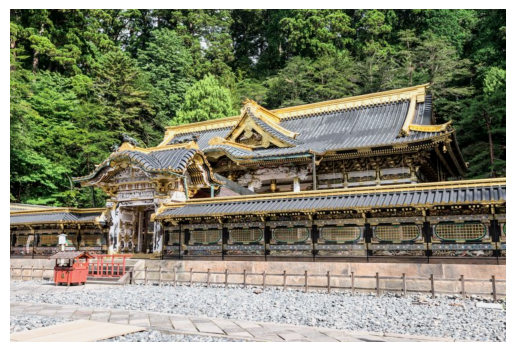

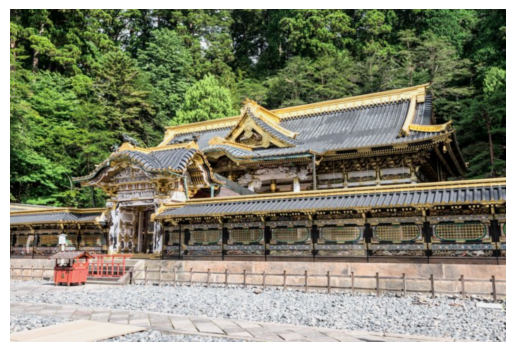

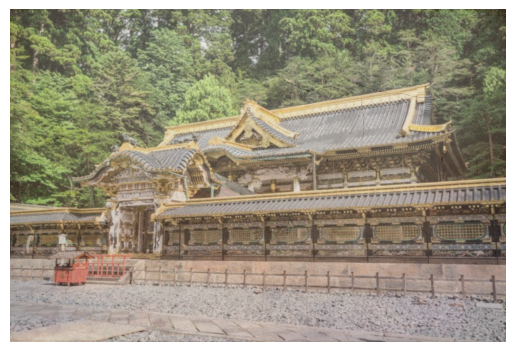

In [31]:
sharpen_image("../Pic/Scene2/PTempleOfNiko.png", "../Pic/Scene2/1.png")

histogram_equalization_color("../Pic/Scene2/1.png", "../Pic/Scene2/2.png")

adjust_brightness("../Pic/Scene2/2.png", "../Pic/Scene2/3.png", 0.95)

blur_image("../Pic/Scene2/3.png", "../Pic/Scene2/4.png")

overlay_texture("../Pic/Scene2/4.png", "../Pic/Scene2/Texture.png", "../Pic/Scene2/5.png")

Scrolable text

In [33]:
image_path = "../Pic/Scene2/5.png"
text = "Welcome to Temple of Nikko"
output_video_path = "../Processed Pic/Scene2.mp4"

add_bold_scrolling_text_to_image(image_path, text, output_video_path, duration=10, text_speed=10, text_size=100, text_color=(207, 161, 107))


Video saved as ../Processed Pic/Scene2.mp4
